# Kaggle Challenge: Metastatic Cancer Diagnosis Prediction
*Equity in Healthcare*

## Notebook #1
*This is the 1st of 3 notebooks for the WiDS Datathon 2024 Challenge #1 Kaggle challenge that ran from 1/9/2024 to 3/1/2024.*

Main challenge page link: https://www.kaggle.com/competitions/widsdatathon2024-challenge1/overview

Below is the complete process of initial exploratory data anaylsis, preprocessing, cleaning, visualization, feature engineering, and saving the final training and testing data for ML model benchmarking.

### Background/Overview
*Breast cancer is the most common cancer in women in the United States, except for skin cancers. According to the American Cancer Society, it accounts for about 30% (or 1 in 3) of all new female cancers each year. The challenge here is to figure out how machine learning can be leveraged in making cancer diagnosis predictions. For more context about the data please see the Data tab in the main challenge page link above.*

*Note: When running or exploring this notebook. To prevent your browser from crashing from lack of compute, just run the cells you need. If you run every cell, when you save the notebook, your notebook file size will run upwards of up to 55+ MB >. So be mindful of this.*

### Exploratory Data Analysis, Data Preprocessing, Data Cleaning, Data Visualization, and Feature Engineering on Training and Test Data

In [1]:
# Load libraries, packages, and tools needed
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

# Load and read datasets
df = pd.read_csv("training.csv") # dataset for training model
tdf = pd.read_csv("test.csv") # dataset for testing the model

#### Training Set

In [2]:
# training dataset
df.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [4]:
df.shape, tdf.shape

((12906, 83), (5792, 82))

In [3]:
# Layout of features for training dataset
numerical_features = df.select_dtypes(include=[np.number])
categorical_features = df.select_dtypes(include=[object])

num_numerical_values = numerical_features.shape[1]
num_categorical_values = categorical_features.shape[1]

print("Total number of numerical features:", num_numerical_values)
print("Total number of categorical features:", num_categorical_values)

Total number of numerical features: 72
Total number of categorical features: 11


*The target variable for metastatic cancer diagnosis prediction is the column titled DiagPeriodL90D where 0 is no diagnosis and 1 is diagnosed*

In [4]:
class_counts = df['DiagPeriodL90D'].value_counts()
print(class_counts)

DiagPeriodL90D
1    8060
0    4846
Name: count, dtype: int64


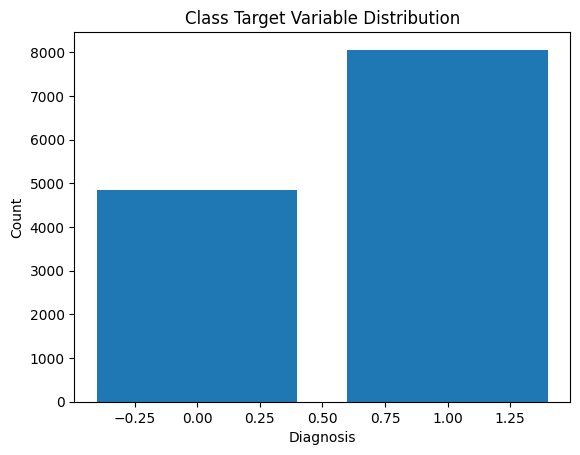

In [5]:
# This is the metastatic cancer prediction or target variable
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Class Target Variable Distribution')
# plt.savefig('target-variable.png', dpi=300) # Save Image
plt.show()

In [ ]:
df.describe()

In [ ]:
df.columns

In [ ]:
df.isnull().sum()

In [ ]:
pd.set_option('display.max_rows', None)
ndf = df.isnull().sum()
ndf = pd.DataFrame(ndf, columns=['Null Count'])
ndf

In [ ]:
# Calculate total number of rows
total_rows = len(df)
# Calculate percentage of null values for each column
npdf = (ndf / total_rows) * 100
percent = {'Null Count': 'Null Count Percentage'}
npdf = npdf.rename(columns= percent)
npdf

*The values in 4 categorical features stand out here BMI, patient race and ethnicity, and metastatic first novel treatment and type. Would this heavily skew or have a huge effect in ML model predictions? I believe so. I believe it effects biases and accuracy in predictive accuracy of a model.*

In [ ]:
df.iloc[:, list(range(11,13))] 

*taking a look at the metastatic first novel treatment and types. 99.8% of these 2 features were null in the training dataset*

In [ ]:
age = df.iloc[:, [5] + list(range(17, 27)) + [82]] # looking at age characteristics in the training data vs diagnosis period
age 

*A lot of the features (columns) in the training dataset are categorical ("object"). Will use OneHotEncoder from scikit-learn and Pandas to convert categorical values to numerical and boolean values*

In [ ]:
df.dtypes

*These are all of the columns with dtypes = object aka string outputs. Will look more in-depth into all of the categorical features. These look like important features specficially the cancer diagnosis columns since this is the main focus of this challenge*

In [ ]:
for d in df.columns: 
    if df[d].dtype == 'object':
        print(d)

In [ ]:
# filtering out the categorical features to take a closer look
def cat_filter(df):
    categorical_columns = []
    for column in df.columns:
        if df[column].dtype == 'object':
            categorical_columns.append(column)
    return df[categorical_columns]

In [ ]:
c = cat_filter(df)
c

#### Feature Enginering: One-Hot Encoding Categorical Features

*We'll one-hot encode all of the categorical features here and then do some data visualization afterward to see the bigger picture.*

In [5]:
# One-hot encoding categorical features with Pandas
pd_df = pd.get_dummies(df, columns=['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                                      'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                                      'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                                      'metastatic_first_novel_treatment_type', 'Region', 'Division'], drop_first=True)

In [ ]:
pd_df.head()

In [6]:
pd_df.shape

(12906, 279)

In [ ]:
pd_df.dtypes

In [7]:
# One hot encoding categorical features with sci-kit learn
categorical_columns = ['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                        'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                        'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                        'metastatic_first_novel_treatment_type', 'Region', 'Division']
                                      
encoder = OneHotEncoder(sparse_output=False)
dfe = encoder.fit_transform(df[categorical_columns])
dfe2 = pd.DataFrame(dfe, columns=encoder.get_feature_names_out(categorical_columns))
skl_df = pd.concat([df, dfe2], axis=1)

In [8]:
skl_df.shape

(12906, 308)

In [9]:
# Dropping column features that have been one-hot encoded for sci-kit learn training dataset because of redundancy
skl_df = skl_df.drop(['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                        'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                        'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                        'metastatic_first_novel_treatment_type', 'Region', 'Division'], axis=1)

In [ ]:
skl_df.head()

In [10]:
skl_df.shape

(12906, 297)

*One-hot encoding converts columns that are strings, or characters, and object data types to a more uniform format that the ML model can use for computing. It looks like pandas get_dummmies() function one-hot encodes categorical features into boolean values and sci-kit learn's OneHotEncoder() function encodes the same features into numerical 0's and 1's. It looks like we now have 2 training sets from one-hot encoding. One set has one-hot encoded categorical features that are of True/False boolean values, and the other numerical. Lets look into the null values*

#### Null Values

In [ ]:
pd.set_option('display.max_rows', None)
ndf = pd_df.isnull().sum()
ndf = pd.DataFrame(ndf, columns=['Null Count'])
ndf

In [ ]:
pd.set_option('display.max_rows', None)
ndf1 = skl_df.isnull().sum()
ndf2 = pd.DataFrame(ndf1, columns=['Null Count'])
ndf2

In [ ]:
pd_df['bmi'].shape

In [ ]:
skl_df['bmi'].shape

*Body mass index (BMI) is an important indicator of the overall health of an individual. Here there are a total of 12,906 patients, though 8,965 patients BMI is not accounted for. For both training sets, we will assume the average BMI to account for patients' missing health information*

In [11]:
# replace null bmi patient values with average bmi for both training sets
bmi_mean = pd_df['bmi'].mean()
bmi_mean2 = skl_df['bmi'].mean()

pd_df['bmi'].fillna(bmi_mean, inplace=True)
skl_df['bmi'].fillna(bmi_mean2, inplace=True)

/tmp/ipykernel_64/2004104560.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pd_df['bmi'].fillna(bmi_mean, inplace=True)
/tmp/ipykernel_64/2004104560.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [12]:
pd_df.fillna(0, inplace=True)
skl_df.fillna(0, inplace=True)

In [13]:
null_proportions = pd_df.isnull().mean()
columns_any_null_values = null_proportions[null_proportions > 0.0]
num_columns_with_any_null_values = columns_any_null_values.shape[0]

print("Total number of features with any null values:", num_columns_with_any_null_values)

Total number of features with any null values: 0


In [14]:
null_proportions = skl_df.isnull().mean()
columns_any_null_values = null_proportions[null_proportions > 0.0]
num_columns_with_any_null_values = columns_any_null_values.shape[0]

print("Total number of features with any null values:", num_columns_with_any_null_values)

Total number of features with any null values: 0


#### Data Shape

In [13]:
pd_df.shape, skl_df.shape

((12906, 279), (12906, 297))

#### Test Set

In [15]:
# test dataset
tdf.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,White,MEDICAID,IN,467,54,F,NaN,C50412,Malig neoplasm of upper-outer quadrant of left...,...,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,593679,NaN,COMMERCIAL,FL,337,52,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,184532,Hispanic,MEDICAID,CA,917,61,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,447383,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
4,687972,Black,NaN,CA,900,40,F,23.0,C50412,Malig neoplasm of upper-outer quadrant of left...,...,45.526154,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261


In [16]:
# Layout of features for training dataset
numerical_features = tdf.select_dtypes(include=[np.number])
categorical_features = tdf.select_dtypes(include=[object])

num_numerical_values = numerical_features.shape[1]
num_categorical_values = categorical_features.shape[1]

print("Total number of numerical features:", num_numerical_values)
print("Total number of categorical features:", num_categorical_values)

Total number of numerical features: 71
Total number of categorical features: 11


In [14]:
# One-hot encoding categorical features with Pandas
pd_tdf = pd.get_dummies(tdf, columns=['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                                      'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                                      'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                                      'metastatic_first_novel_treatment_type', 'Region', 'Division'], drop_first=True)

*The training and testing data have different number of features.*

In [16]:
pd_df.shape, pd_tdf.shape

((12906, 279), (5792, 259))

In [17]:
# One hot encoding categorical features with sci-kit learn
categorical_columns = ['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                        'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                        'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                        'metastatic_first_novel_treatment_type', 'Region', 'Division']
                                      
encoder = OneHotEncoder(sparse_output=False)
tdfe = encoder.fit_transform(tdf[categorical_columns])
tdfe2 = pd.DataFrame(tdfe, columns=encoder.get_feature_names_out(categorical_columns))
skl_tdf = pd.concat([tdf, tdfe2], axis=1)

In [18]:
# Dropping column features that have been one-hot encoded for sci-kit learn test dataset because of redundancy
skl_tdf = skl_tdf.drop(['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                        'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                        'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                        'metastatic_first_novel_treatment_type', 'Region', 'Division'], axis=1)

In [19]:
# replace null bmi patient values with average bmi for both test sets
bmi_mean = pd_tdf['bmi'].mean()
bmi_mean2 = skl_tdf['bmi'].mean()

pd_tdf['bmi'].fillna(bmi_mean, inplace=True)
skl_tdf['bmi'].fillna(bmi_mean2, inplace=True)

/tmp/ipykernel_64/515737107.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pd_tdf['bmi'].fillna(bmi_mean, inplace=True)
/tmp/ipykernel_64/515737107.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [20]:
pd_tdf.fillna(0, inplace=True)
skl_tdf.fillna(0, inplace=True)

In [22]:
null_proportions = pd_tdf.isnull().mean()
columns_any_null_values = null_proportions[null_proportions > 0.0]
num_columns_with_any_null_values = columns_any_null_values.shape[0]

print("Total number of features with any null values:", num_columns_with_any_null_values)

Total number of features with any null values: 0


In [23]:
null_proportions = skl_tdf.isnull().mean()
columns_any_null_values = null_proportions[null_proportions > 0.0]
num_columns_with_any_null_values = columns_any_null_values.shape[0]

print("Total number of features with any null values:", num_columns_with_any_null_values)

Total number of features with any null values: 0


#### Data Shape

In [21]:
pd_df.shape, pd_tdf.shape, skl_df.shape, skl_tdf.shape

((12906, 279), (5792, 259), (12906, 297), (5792, 277))

In [51]:
# Get the column names of Pandas training and testing data
pdf_columns = set(pd_df.columns)
ptdf_columns = set(pd_tdf.columns)

# Find common columns
common_columns = pdf_columns.intersection(ptdf_columns)
print("Common features:", len(common_columns))

# Find columns present in pd_df but not in pd_tdf
pd_df_not_pd_tdf = pdf_columns.difference(ptdf_columns)
print("Features in training set pd_df but not in testing set pd_tdf:", len(pd_df_not_pd_tdf))

# Find columns present in pd_tdf but not in pd_df
pd_tdf_not_pd_df = ptdf_columns.difference(pdf_columns)
print("Features in testing set pd_tdf but not in training set pd_df:", len(pd_tdf_not_pd_df))

Common features: 255
Features in training set pd_df but not in testing set pd_tdf: 24
Features in testing set pd_tdf but not in training set pd_df: 4


#### Data Visualization

*Since categorical features were one-hot encoded, the categorical features are spread out into numerical feature columns which also includes the 72 features that were originally numerical in nature. So the original 11 categorical features may be spread out over 20+> columns now. This is too many columns for a heatmap to bring any meaningful correlational insights. You can plot it out, though depending on your compute, it may take a little to render or plot. One interesting note I discovered however, is when you plot the heatmap focusing on the target variable, N02 has a strong correlation with the DiagPeriodL90D column*

### Heatmap

In [ ]:
correlation_matrix= pd_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="viridis",linewidth=0.5, fmt=".2f",annot_kws={"size": 12})
plt.show()

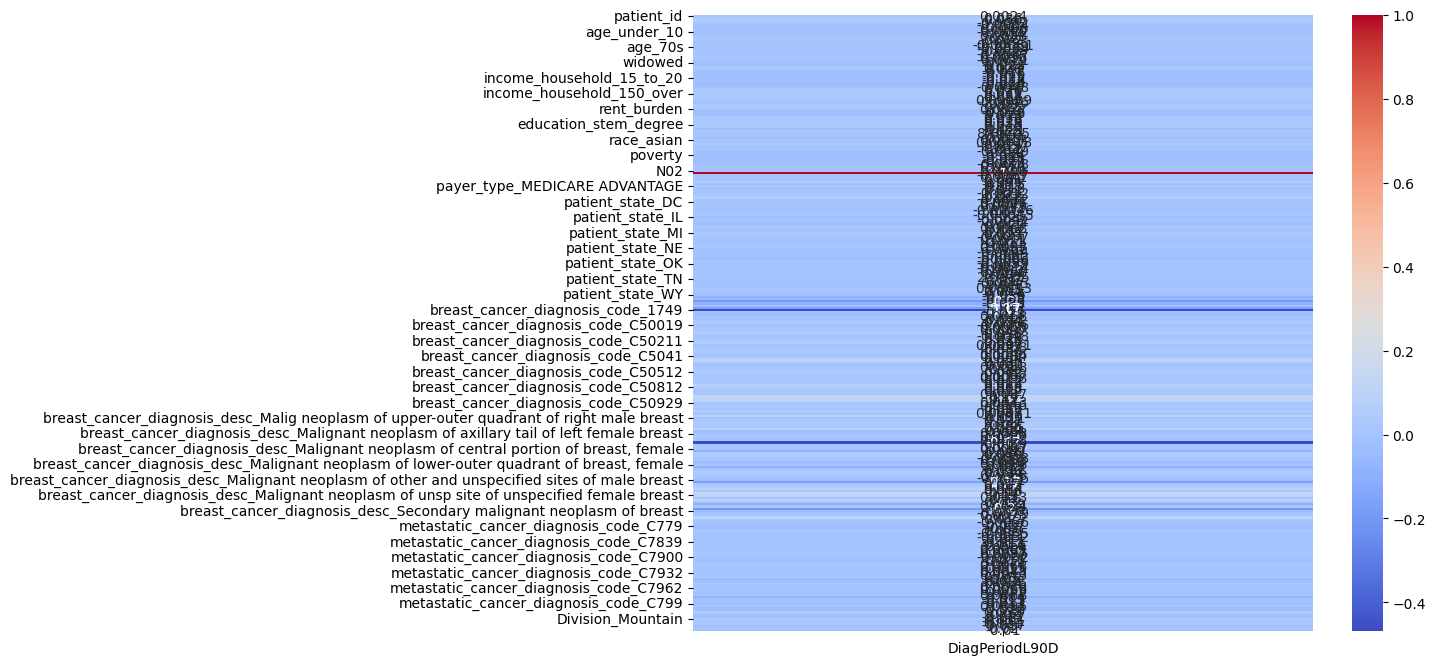

In [24]:
corr_matrix = pd_df.corr()
# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['DiagPeriodL90D']], annot=True, cmap='coolwarm')
plt.show()

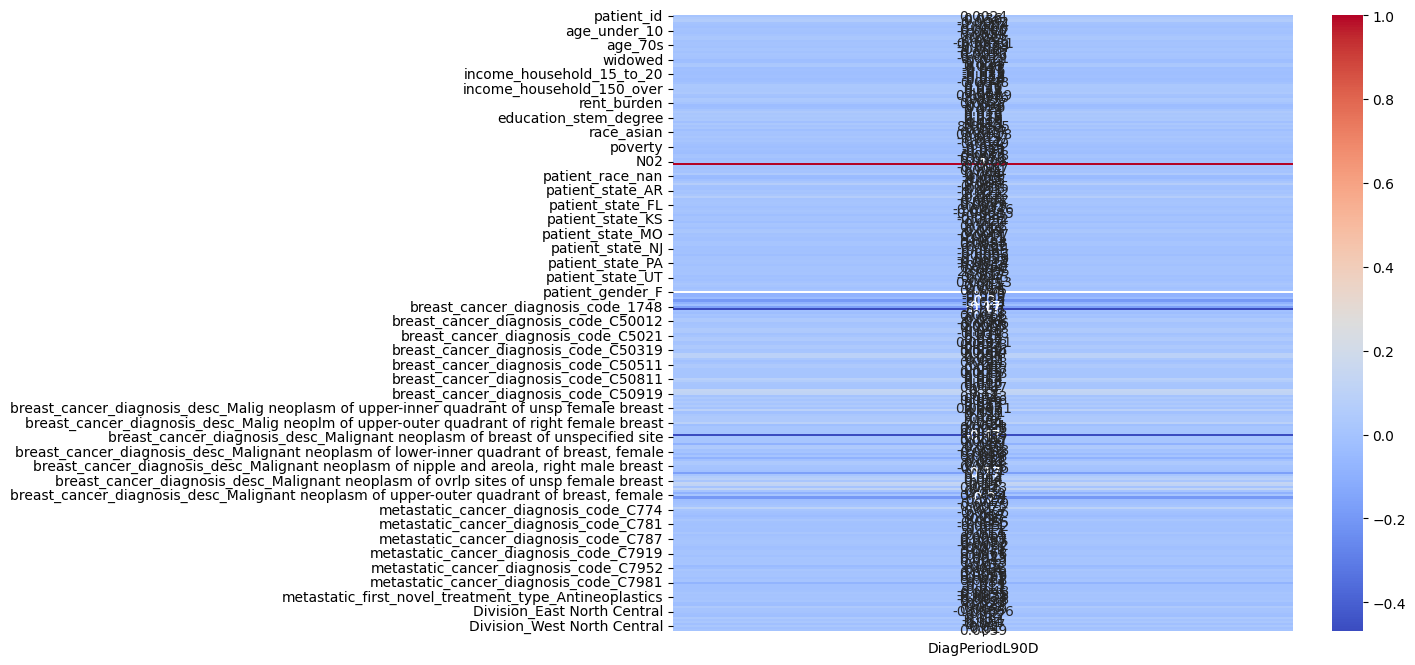

In [25]:
corr_matrix = skl_df.corr()
# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['DiagPeriodL90D']], annot=True, cmap='coolwarm')
# plt.savefig('scikitlearn-train-heatmap.png', dpi=300) # Save Image
plt.show()

*According to the World Health Organization (WHO), annual average outdoor NO2 levels should not exceed 40 micrograms/m^3*

In [ ]:
skl_df['N02'].describe()

In [ ]:
pd_df['N02'].describe()

*When checking the heatmap on the test set that will be used for testing models, if you set the N02 as the target variable, you see some correlations in the plot*

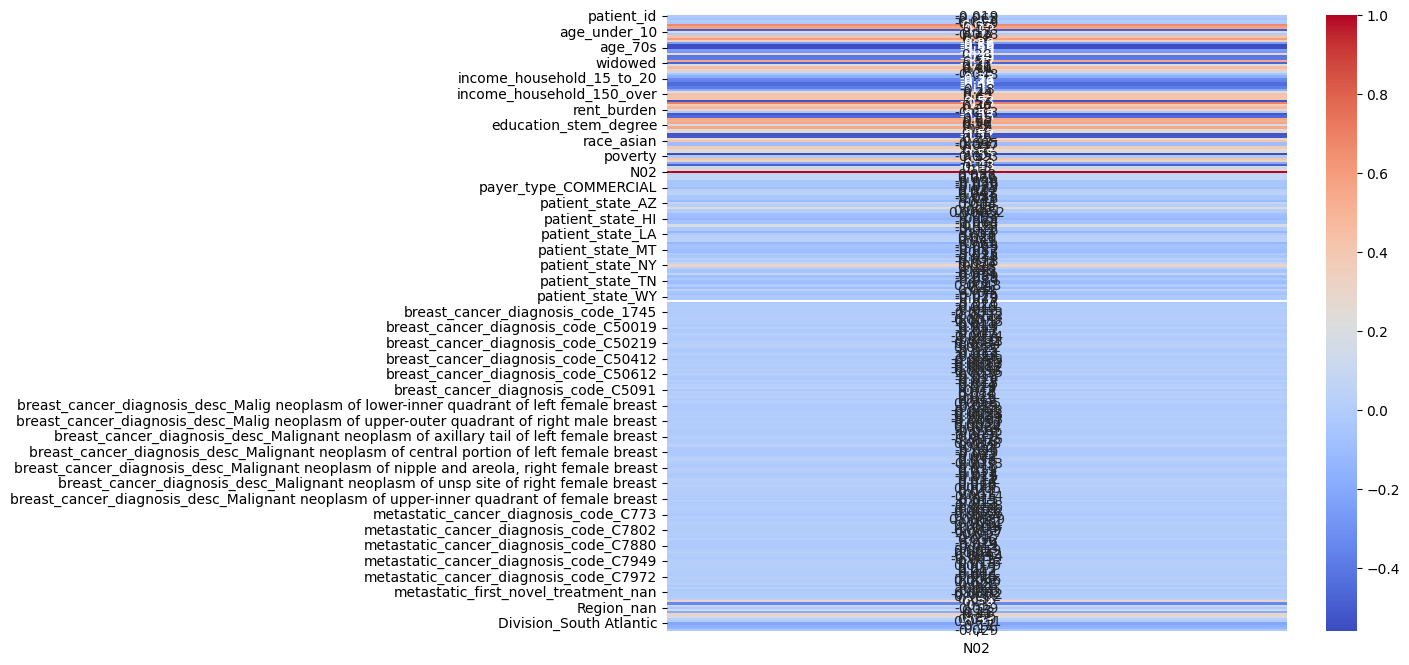

In [26]:
# Checking for any correlation between N02 and any other features in test dataset
corr_matrix = skl_tdf.corr()
# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['N02']], annot=True, cmap='coolwarm')
# plt.savefig('scikitlearn-test-heatmap.png', dpi=300) # Save image
plt.show()

In [ ]:
fig, axs = plt.subplots(len(skl_df.columns), 1, figsize=(5, 2*len(skl_df.columns)))

for i, col in enumerate(skl_df.columns):
    axs[i].hist(skl_df[col].dropna(), bins=30)  # dropna to remove missing values
    axs[i].set_title('Histogram of ' + col)

plt.tight_layout()  # adjusts subplot params so that subplots fit into the figure area
plt.show()

In [ ]:
def compare_distributions(df, column_name, selections, **kwargs):
    hist_data = {}
    
    # Pre-compute histograms for each selection
    for label, selection in selections.items():
        selected_data = df[selection][column_name].dropna()  # drop NaN values
        if selected_data.empty:  # check if selected data is empty after dropping NaN values
            print(f'Skipped {column_name} for {label} (All NaNs)')
            continue
        hist_data[label] = np.histogram(selected_data, **kwargs)
    
    # Plot the pre-computed histograms
    for label, hist in hist_data.items():
        plt.hist(hist[1][:-1], bins=hist[1], weights=hist[0], label=label, alpha=0.5)
    
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()

#### Histogram

In [ ]:
num_rows = math.ceil(len(pd_df.columns) / 3)
num_cols = 3 if len(pd_df.columns) > 3 else len(pd_df.columns)

plt.figure(figsize=(15, 5 * num_rows))
#plt.figure(figsize=(17, 17))
selection_dict = {"Diagnosis": pd_df["DiagPeriodL90D"] == 1, "No Diagnosis": pd_df["DiagPeriodL90D"] == 0}

for i, column_name in enumerate(pd_df.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    compare_distributions(df, column_name, selection_dict, density=1, bins=25)

plt.tight_layout()
plt.show()

In [ ]:
sns.pairplot(pd_df.dropna())

# Display the plot
plt.show()

#### Save Train and Test Data in CSV Files for ML Model Training

In [27]:
# Only need to save the test and training sets once
train = pd_df.to_csv('pandas-train.csv', index=False)
train2 = skl_df.to_csv('scikitlearn-train.csv', index=False)
test = pd_tdf.to_csv('pandas-test.csv', index=False)
test2 = skl_tdf.to_csv('scikitlearn-test.csv', index=False)

*You can use these new training and test sets for model benchmarking in Notebook #2 and #3*